In [1]:
from xbpy.morgan import substructure_match, unique_index, morgan_prop
from xbpy.rdutil import read_molecules, position
from rdkit.Chem.rdmolops import RenumberAtoms
from rdkit import Chem
from rdkit.Chem import rdDetermineBonds
import numpy as np
import pymolviz as pmv

In [2]:
reference_mol = next(read_molecules("combined_reference.pdb"))
substructure_difficult = next(read_molecules("substructure_difficult_test.pdb"))
matching_mols = list(read_molecules("Bromobenzene_BB_MP2-TZVPP_pre2024.sdf"))

In [3]:
new_reference_mol = RenumberAtoms(reference_mol, [int(i) for i in np.argsort(unique_index(reference_mol))])
new_matching_mol = RenumberAtoms(matching_mols[0], [int(i) for i in np.argsort(unique_index(matching_mols[0]))])

In [4]:
Chem.MolToPDBFile(new_reference_mol, "new_reference.pdb")
Chem.MolToPDBFile(new_matching_mol, "new_matching.pdb")

In [5]:
xyz_file = next(read_molecules("new_xyz.pdb"))

In [6]:
rdDetermineBonds.DetermineConnectivity(xyz_file)

In [7]:
Chem.MolToPDBFile(xyz_file, "proximity_bonded.pdb")

In [8]:

new_xyz_mol = RenumberAtoms(xyz_file, [int(i) for i in np.argsort(unique_index(xyz_file))])

In [9]:
visualization_group = pmv.Group(name = "visualization_group")

In [10]:
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

#def morgan_unique_matching(mol1, mol2):
mol1 = substructure_difficult
mol2 = new_xyz_mol

positions1 = position(list(mol1.GetAtoms()))
positions2 = position(list(mol2.GetAtoms()))

mol1_adj = GetAdjacencyMatrix(mol1)
mol2_adj = GetAdjacencyMatrix(mol2)
mol1_vector = np.array([[0, 1] for a in mol1.GetAtoms()])    
mol2_vector = np.array([[0, 1] for a in mol2.GetAtoms()])    

mol1_match_mol2 = np.full(mol1_vector.shape[0], -1, dtype=int)
mol2_match_mol1 = np.full(mol2_vector.shape[0], -1, dtype=int)

# find equivalence classes so far:
mol1_equiv = {(tuple(val),) : np.where((mol1_vector[:, 0] == val[0]) & (mol1_vector[:, 1] == val[1]))[0] for val in np.unique(mol1_vector, axis=0)}
mol2_equiv = {(tuple(val),) : np.where((mol2_vector[:, 0] == val[0]) & (mol2_vector[:, 1] == val[1]))[0] for val in np.unique(mol2_vector, axis=0)}

unmatched_indices_1 = []
unmatched_indices_2 = []

# find matches so far:
state = 1
assigned_count = 0
changes = True
while(len(mol1_equiv) > 0 and len(mol2_equiv) > 0):
    if not changes:
        # only ambiguities left, assign arbitrary
        val, indices1 = mol1_equiv.popitem()
        indices2 = mol2_equiv.pop(val)
        for index1, index2 in zip(indices1, indices2):
            # TODO: should be at least determined by distance to origin!
            mol1_vector[index1][0] = assigned_count
            mol2_vector[index2][0] = assigned_count
            mol1_match_mol2[index1] = index2
            mol2_match_mol1[index2] = index1
            assigned_count += 1
        if len(indices1) >= len(indices2):
            # assign remaining indices2 to unmatched_indices_2
            unmatched_indices_2.extend(indices2[len(indices1):])
        else:
            unmatched_indices_1.extend(indices1[len(indices2):])
    to_remove_1 = []
    to_remove_2 = []
    for val, val_atom_indices in mol1_equiv.items():
        if len(val_atom_indices) == 1 and len(mol2_equiv.get(val, [])) == 1:
            mol1_vector[val_atom_indices[0]][0] = assigned_count 
            mol2_vector[mol2_equiv[val][0]][0] = assigned_count
            assigned_count += 1
            mol1_match_mol2[val_atom_indices[0]] = mol2_equiv[val][0]
            mol2_match_mol1[mol2_equiv[val][0]] = val_atom_indices[0]
            to_remove_1.append(val)
            to_remove_2.append(val)
        elif val not in mol2_equiv:
            unmatched_indices_1.extend(val_atom_indices)
            to_remove_1.append(val)
    for val, val_atom_indices in mol2_equiv.items():
        if val not in mol1_equiv:
            unmatched_indices_2.extend(val_atom_indices)
            to_remove_2.append(val)
    
    for val in to_remove_1:
        del mol1_equiv[val]
    for val in to_remove_2:
        del mol2_equiv[val]

    next_vector_1 = mol1_adj @ mol1_vector
    next_vector_1[mol1_match_mol2 != -1] = mol1_vector[mol1_match_mol2 != -1] # assigned atoms don't change their values any more
    mol1_vector = next_vector_1
    next_vector_2 = mol2_adj @ mol2_vector
    next_vector_2[mol2_match_mol1 != -1] = mol2_vector[mol2_match_mol1 != -1] # assigned atoms don't change their values any more
    mol2_vector = next_vector_2
    next_mol1_equiv = {}
    changes = False
    for val, equiv_atom_indices in mol1_equiv.items():
        mol1_values = mol1_vector[equiv_atom_indices]
        new_values = {(*val, tuple(new_val)) : equiv_atom_indices[np.where((mol1_values[:, 0] == new_val[0]) & (mol1_values[:, 1] == new_val[1]))[0]] for new_val in np.unique(mol1_values, axis = 0)}
        next_mol1_equiv.update(new_values)
        if len(new_values) > 1:
            changes = True

    next_mol2_equiv = {}
    for val, equiv_atom_indices in mol2_equiv.items():
        mol2_values = mol2_vector[equiv_atom_indices]
        new_values = {(*val, tuple(new_val)) : equiv_atom_indices[np.where((mol2_values[:, 0] == new_val[0]) & (mol2_values[:, 1] == new_val[1]))[0]] for new_val in np.unique(mol2_values, axis = 0)}
        next_mol2_equiv.update(new_values)
        if len(new_values) > 1:
            changes = True
    mol1_equiv = next_mol1_equiv
    mol2_equiv = next_mol2_equiv
    print(f"{mol1_match_mol2=}")
    visualize_positions = []
    labels = []
    for val, equiv_atom_indices in mol1_equiv.items():
        visualize_positions.extend(positions1[equiv_atom_indices])
        labels.extend([str(val)] * len(equiv_atom_indices))
    visualization_group.append(pmv.Labels(visualize_positions, labels, name = f"mol1_equiv", state = state))
    visualize_positions = []
    labels = []
    for val, equiv_atom_indices in mol2_equiv.items():
        visualize_positions.extend(positions2[equiv_atom_indices])
        labels.extend([str(val)] * len(equiv_atom_indices))
    visualization_group.append(pmv.Labels(visualize_positions, labels, name = f"mol2_equiv", state = state))
    state += 1
    




print(mol1_match_mol2)
print(mol2_match_mol1)
print(unmatched_indices_1)
print(unmatched_indices_2)
# deal with unmatched atoms:
"""
# construct kdtree from matched atoms in mol1
from scipy.spatial import cKDTree, Delaunay
mol1_matched_atoms = mol1.GetAtoms()[mol1_match_mol2 != -1]
mol1_matched_positions = position(mol1_matched_atoms)
mol1_matched_tree = cKDTree(mol1_matched_positions)
mol2_matched_atoms = mol2.GetAtoms()[mol2_match_mol1 != -1][mol2_match_mol1[mol2_match_mol1 != -1]]
mol2_matched_positions = position(mol2_matched_atoms)
mol2_matched_tree = cKDTree(mol2_matched_positions)

# try to determine matching atom by position relative to 3 closest matched atoms
unmatched_coordinates1 = []
for unmatched_index1 in unmatched_indices_1:
    unmatched_closest_indices = mol1_matched_tree.query(mol1.GetConformer().GetAtomPosition(unmatched_index1), k = 3)[1]
    unmatched_closest_positions = mol1_matched_positions[unmatched_closest_indices]
    delauney = Delaunay(unmatched_closest_positions)

"""


# for equivalence classes with multiple atoms for either molecule, repeat:
        


mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])
mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])
mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])
mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])
mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])
mol1_match_mol2=array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1])


KeyError: ((0, 1), (0, 1), (0, 3), (0, 7), (0, 17), (0, 41), (0, 99))

In [ ]:
visualization_group.write("visualization_group.py")

In [ ]:
# instead match by topology first:

vector_mol1 = np.ones((mol1.GetNumAtoms()))
vector_mol2 = np.ones((mol2.GetNumAtoms()))

mol1_adj = GetAdjacencyMatrix(mol1)
mol2_adj = GetAdjacencyMatrix(mol2)

visualization_group = pmv.Group(name = "visualization_group")
state = 1
next_vector_mol1 = mol1_adj @ vector_mol1
visualization_group.append(pmv.Points(position(list(mol1.GetAtoms())), vector_mol1, name = "mol1", state = state))
visualization_group.append(pmv.Labels(position(list(mol1.GetAtoms())), labels=vector_mol1, name = "mol1_labels", state = state))
next_vector_mol2 = mol2_adj @ vector_mol2
visualization_group.append(pmv.Points(np.array(position(list(mol2.GetAtoms()))), vector_mol2, name = "mol2", state = state))
visualization_group.append(pmv.Labels(np.array(position(list(mol2.GetAtoms()))), labels=vector_mol2, name = "mol2_labels", state = state))
histories_mol1 = [vector_mol1]
histories_mol2 = [vector_mol2]

while np.any(np.argsort(next_vector_mol1) != np.argsort(vector_mol1)):
    vector_mol1 = next_vector_mol1
    vector_mol2 = next_vector_mol2
    histories_mol1.append(vector_mol1)
    histories_mol2.append(vector_mol2)
    print(np.vstack(histories_mol1))
    values, indices, counts = np.unique(np.vstack(histories_mol1).T, axis = 0, return_counts = True, return_index=True)
    print(f"{values=}, {counts=}, {indices=}")


    state += 1
    visualization_group.append(pmv.Points(position(list(mol1.GetAtoms())), vector_mol1, name = "mol1", state = state))
    visualization_group.append(pmv.Labels(position(list(mol1.GetAtoms())), labels=vector_mol1, name = "mol1_labels", state = state))
    visualization_group.append(pmv.Points(np.array(position(list(mol2.GetAtoms())) ), vector_mol2, name = "mol2", state = state))
    visualization_group.append(pmv.Labels(np.array(position(list(mol2.GetAtoms()))), labels=vector_mol2, name = "mol2_labels", state = state))
    next_vector_mol1 = mol1_adj @ vector_mol1
    next_vector_mol2 = mol2_adj @ vector_mol2
    if state > 3:
        break
visualization_group.write("topolgy_based.py")

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [3. 2. 3. 1. 4. 4. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
values=array([[1., 1.],
       [1., 2.],
       [1., 3.],
       [1., 4.]]), counts=array([13,  1,  7,  2]), indices=array([3, 1, 0, 4])
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [3. 2. 3. 1. 4. 4. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [8. 6. 8. 3. 6. 6. 7. 6. 7. 7. 6. 3. 3. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3.]]
values=array([[1., 1., 3.],
       [1., 1., 4.],
       [1., 2., 6.],
       [1., 3., 6.],
       [1., 3., 7.],
       [1., 3., 8.],
       [1., 4., 6.]]), counts=array([7, 6, 1, 2, 3, 2, 2]), indices=array([ 3, 13,  1,  7,  6,  0,  4])
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.]
 [ 3.  2.  3.  1.  4.  4.  3.  3.  3.  3.  3.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.]
 [ 8.  6.  8.  3.  6.  6.  7.  6.  7.  7.  6.  3.  3.  4.  4.  4.  4. 

In [ ]:
mol = mol1
def topology_history(mol):
    vector = np.ones((mol.GetNumAtoms()))
    adj = GetAdjacencyMatrix(mol)
    next_vector = adj @ vector
    histories = []
    last_unique = None
    while last_unique != (last_unique := len(np.unique(vector))):
        histories.append(vector)
        vector = next_vector
        next_vector = adj @ vector
        #next_vector /= np.linalg.norm(next_vector)
    return np.around(np.vstack(histories).T, 5)

In [ ]:
mol1 = substructure_difficult
mol2 = new_xyz_mol

In [ ]:
history1 = topology_history(mol1)
history1_group = pmv.Group(name = "history1_group")
state = 1
for hist in history1.T:
    history1_group.append(pmv.Labels(position(list(mol1.GetAtoms())), labels=hist, name = "mol1_history", state = state))
    state += 1
history1_group.write("history1.py")

In [ ]:
history2 = topology_history(mol2)
history2_group = pmv.Group(name = "history2_group")
state = 1
for hist in history2.T:
    history2_group.append(pmv.Labels(position(list(mol2.GetAtoms())), labels=hist, name = "mol2_history", state = state))
    state += 1
history2_group.write("history2.py")

In [ ]:
history2 = topology_history(mol2)

In [ ]:
np.unique(history1, axis = 0)

array([[  1.,   1.,   3.,   6.,  16.,  34.],
       [  1.,   1.,   3.,   7.,  16.,  40.],
       [  1.,   1.,   3.,   7.,  17.,  39.],
       [  1.,   1.,   3.,   8.,  17.,  45.],
       [  1.,   1.,   4.,   6.,  20.,  35.],
       [  1.,   2.,   6.,  12.,  32.,  68.],
       [  1.,   3.,   6.,  16.,  34.,  88.],
       [  1.,   3.,   7.,  16.,  40.,  89.],
       [  1.,   3.,   7.,  17.,  39.,  97.],
       [  1.,   3.,   8.,  17.,  45.,  97.],
       [  1.,   4.,   6.,  20.,  35., 105.]])

In [ ]:
# going down from longest history, we search for same values in both histories
# if we find a match, we can assign the atoms to each other

history_comparison

for i in range(min(history1.shape[1], history2.shape[1]), 0, -1):
    vals, indices = np.unique(history1[:, :i], axis = 0, return_inverse = True)
    history1_dict = {tuple(val) : np.where(indices == i)[0] for i, val in enumerate(vals)}
    vals, indices = np.unique(history2[:, :i], axis = 0, return_inverse = True)
    history2_dict = {tuple(val) : np.where(indices == i)[0] for i, val in enumerate(vals)}
    intersections = set(history1_dict.keys()).intersection(set(history2_dict.keys()))
    print(f"iteration {i}")
    for intersection in intersections:
        # we found a match
        
        print(f"Matching atoms {history1_dict[intersection]} to {history2_dict[intersection]}")
        print(intersection)

iteration 6
iteration 5
Matching atoms [20] to [16 17 19]
(1.0, 1.0, 3.0, 7.0, 17.0)
iteration 4
Matching atoms [11 20 21] to [ 8  9 16 17 19]
(1.0, 1.0, 3.0, 7.0)
Matching atoms [13 14 15 16 17 18] to [21 22 23]
(1.0, 1.0, 4.0, 6.0)
Matching atoms [8] to [14 15 18]
(1.0, 3.0, 7.0, 17.0)
iteration 3
Matching atoms [ 3 11 12 19 20 21 22] to [ 7  8  9 16 17 19]
(1.0, 1.0, 3.0)
Matching atoms [6 8 9] to [ 5  6 14 15 18]
(1.0, 3.0, 7.0)
Matching atoms [4 5] to [20]
(1.0, 4.0, 6.0)
Matching atoms [13 14 15 16 17 18] to [11 12 13 21 22 23]
(1.0, 1.0, 4.0)
iteration 2
Matching atoms [ 3 11 12 13 14 15 16 17 18 19 20 21 22] to [ 7  8  9 11 12 13 16 17 19 21 22 23]
(1.0, 1.0)
Matching atoms [1] to [0]
(1.0, 2.0)
Matching atoms [ 0  2  6  7  8  9 10] to [ 1  3  4  5  6 14 15 18]
(1.0, 3.0)
Matching atoms [4 5] to [ 2 10 20]
(1.0, 4.0)
iteration 1
Matching atoms [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] to [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 2

In [ ]:
from scipy.optimize import linear_sum_assignment

In [ ]:
M_1 = np.array([[0, 1, 2, 2], [1, 0, 1, 1], [2, 1, 0, 2], [2, 1, 2, 0]])
M_2 = np.array([[0, 1, 1, 1], [1, 0, 2, 2], [1, 2, 0, 2], [1, 2, 2, 0]])

In [ ]:
cost_matrix = M_1.T @ M_2

In [ ]:
assignment = linear_sum_assignment(cost_matrix, maximize=True)

In [ ]:
permutation_matrix = np.zeros(cost_matrix.shape, dtype=int)
permutation_matrix[assignment] = 1

In [ ]:
permutation_matrix

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [ ]:
M_1 = np.array([
    [0, 1, 2, 3, 4, 3, 2, 4],
    [1, 0, 1, 2, 3, 2, 1, 3],
    [2, 1, 0, 1, 2, 3, 2, 2],
    [3, 2, 1, 0, 1, 2, 3, 1],
    [4, 3, 2, 1, 0, 1, 2, 2],
    [3, 2, 3, 2, 1, 0, 1, 3],
    [2, 1, 2, 3, 2, 1, 0, 4],
    [4, 3 ,2, 1, 2, 3 ,4 ,0]])
M_2 = np.array([
    [0, 2, 2, 1, 3, 1, 2, 2],
    [2, 0, 2, 2, 1, 1, 1, 3],
    [2, 2, 0, 3, 3, 1, 3, 4],
    [1, 2, 3, 0, 3, 2, 1, 1],
    [3, 1, 3, 3, 0, 2, 2, 4],
    [1, 1, 1, 2, 2, 0, 2, 3],
    [2, 1, 3, 1, 2, 2, 0, 2],
    [2, 3, 4, 1, 4, 3, 2, 0]])
cost_matrix = M_1.T @ M_2
assignment = linear_sum_assignment(cost_matrix, maximize=True)
permutation_matrix = np.zeros(cost_matrix.shape, dtype=int)
permutation_matrix[assignment] = 1
np.array(list("ABCDEFGH"))[np.arange(8) @ permutation_matrix]

array(['C', 'G', 'A', 'D', 'E', 'B', 'F', 'H'], dtype='<U1')

In [16]:
from collections import deque

def convert_matrix_to_list(graph_matrix):
    adjacency_list = {}
    for i, row in enumerate(graph_matrix):
        adjacency_list[i] = [j for j, val in enumerate(row) if val == 1]
    return adjacency_list

def bfs_shortest_path(graph_list, start):
    distance = [-1 for vertex in graph_list]
    queue = deque([start])

    distance[start] = 0

    while queue:
        vertex = queue.popleft()
        for neighbor in graph_list[vertex]:
            if distance[neighbor] == -1:
                distance[neighbor] = distance[vertex] + 1
                queue.append(neighbor)
    
    return distance

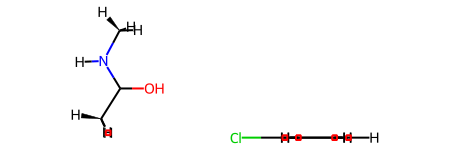

In [17]:
mol1

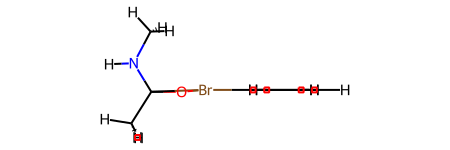

In [18]:
mol2

In [21]:
mol1_adj_list = convert_matrix_to_list(mol1_adj)
mol2_adj_list = convert_matrix_to_list(mol2_adj)

topological_distance_M_mol1 = np.array([bfs_shortest_path(mol1_adj_list, i) for i in range(mol1.GetNumAtoms())])
topological_distance_M_mol2 = np.array([bfs_shortest_path(mol2_adj_list, i) for i in range(mol2.GetNumAtoms())])


In [ ]:
topological_distance_weight = lambda d: np.exp(-d) + 1


In [22]:
topological_distance_M_mol1

array([[ 0,  1,  1,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         2,  3,  3,  3,  2,  2,  2, -1],
       [ 1,  0,  2,  2,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         1,  2,  2,  2,  3,  3,  3, -1],
       [ 1,  2,  0,  2,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         3,  4,  4,  4,  3,  3,  3, -1],
       [ 1,  2,  2,  0,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         3,  4,  4,  4,  1,  1,  1, -1],
       [ 2,  1,  3,  3,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         2,  1,  1,  1,  4,  4,  4, -1],
       [-1, -1, -1, -1, -1,  0,  2,  3,  2,  1,  2,  1,  4,  3,  2,  3,
        -1, -1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  2,  0,  3,  2,  3,  4,  1,  4,  3,  4,  5,
        -1, -1, -1, -1, -1, -1, -1,  3],
       [-1, -1, -1, -1, -1,  3,  3,  0,  1,  2,  1,  2,  1,  2,  3,  2,
        -1, -1, -1, -1, -1, -1, -1,  4],
       [-1, -1, -1, -1, -1,  2,  2,  1,  0,  3,  2,  1,  2,  1,  4,  3,
        -1, -1, -1, -1, 

In [ ]:
history_1 = morgan_prop(new_xyz_mol, return_history=True)

In [ ]:
group = pmv.Group()
for i, h in enumerate(history_1):
    group.append(pmv.Points([position(a) for a in new_xyz_mol.GetAtoms()], h, name = "history_1", state = i + 1))
group.write("history_1.py")

In [ ]:
history_2 = morgan_prop(new_reference_mol, return_history=True)
group = pmv.Group()
for i, h in enumerate(history_2):
    group.append(pmv.Points([position(a)+ [0, 0, 8] for a in new_reference_mol.GetAtoms()], h, name = "history_2", state = i + 1))
group.write("history_2.py")

In [ ]:
substructure_match(new_reference_mol, xyz_file)

[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.        ]
 [  8.           6.           7.           1.           6.
    6.           1.           1.           1.           1.
    1.           1.          35.           6.           6.
    6.           1.           1.           6.           6.
    1.           1.           6.           1.        ]
 [ 14.          13.          11.33333333   8.           8.25
    8.5          7.           7.           7.           7.
    7.           7.          41.          21.66666667  10.33333333
   10.33333333   7.           7.          10.33333333  10.33333333
    7.           7.          10.33333333   7.        ]
 [ 27.          24.19444444  21.16666667  19.33333333  16.75
   16.58333333  15.5         15.5         15.5  

array([ 2, 10,  1, 12,  3,  4, 13, 14, 15, 16, 17, 18, 11,  5,  0,  7, 20,
       22,  8,  6, 21, 19,  9, 23])